In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
Rhoop = 3 # the radius of the hoop
r0 = 1 # the equilibrial length of the springs
kappa = 1 # the spring constant
Nnodes = 21
A = np.zeros((Nnodes,Nnodes),dtype = int) # spring adjacency matrix
# vertical springs
for k in range(3):
    A[k,k+4] = 1
for k in range(4,7):  
    A[k,k+5] = 1
for k in range(9,12):  
    A[k,k+5] = 1
for k in range(14,17):  
    A[k,k+4] = 1
# horizontal springs
for k in range(3,7):
    A[k,k+1] = 1
for k in range(8,12):  
    A[k,k+1] = 1
for k in range(13,17):  
    A[k,k+1] = 1
# symmetrize
Asymm = A + np.transpose(A)
# indices of nodes on the hoop
ind_hoop = [0,3,8,13,18,19,20,17,12,7,2,1]
Nhoop = np.size(ind_hoop)
# indices of free nodes (not attached to the hoop)
ind_free = [4,5,6,9,10,11,14,15,16]
Nfree = np.size(ind_free)
# list of springs
springs = np.array(np.nonzero(A))

Nsprings = np.size(springs,axis=1)
print(springs)


[[ 0  1  2  3  4  4  5  5  6  6  8  9  9 10 10 11 11 13 14 14 15 15 16 16]
 [ 4  5  6  4  5  9  6 10  7 11  9 10 14 11 15 12 16 14 15 18 16 19 17 20]]


In [11]:
# Initialization

# Initial angles for the nodes are uniformly distributed around the range of 2*pi
# startting from theta0 and going counterclockwise
theta0 = 2*np.pi/3
theta = theta0 + np.linspace(0,2*np.pi,Nhoop+1)
theta = np.delete(theta,-1)
# Initial positions
pos = np.zeros((Nnodes,2))
pos[ind_hoop,0] = Rhoop*np.cos(theta)
pos[ind_hoop,1] = Rhoop*np.sin(theta)
pos[ind_free,0] = np.array([-1.,0.,1.,-1.,0.,1.,-1.,0.,1.])
pos[ind_free,1] = np.array([1.,1.,1.,0.,0.,0.,-1.,-1.,-1.]) 

# Initiallize the vector of parameters to be optimized
vec = np.concatenate((theta,pos[ind_free,0],pos[ind_free,1]))

In [12]:
def draw_spring_system(pos,springs,R,ind_hoop,ind_free):
    # draw the hoop
    t = np.linspace(0,2*np.pi,200)
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(R*np.cos(t),R*np.sin(t),linewidth = 5,color = 'red')
    # plot springs
    Nsprings = np.size(springs,axis=1)
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        plt.plot([pos[j0,0],pos[j1,0]],[pos[j0,1],pos[j1,1]],color = 'black',linewidth = 3)    
    # plot nodes
    plt.scatter(pos[ind_hoop,0],pos[ind_hoop,1],s = 300,color = 'crimson')
    plt.scatter(pos[ind_free,0],pos[ind_free,1],s = 300,color = 'black')

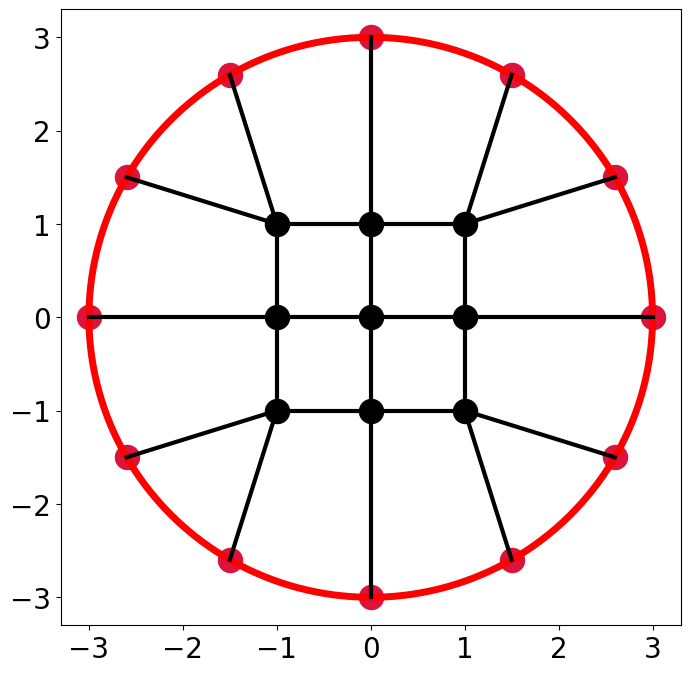

In [13]:
# Draw the initial configuration of the spring system
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)

In [14]:
def compute_gradient(theta,pos,Asymm,r0,kappa,R,ind_hoop,ind_free):
    Nhoop = np.size(ind_hoop)
    g_hoop = np.zeros((Nhoop,)) # gradient with respect to the angles of the hoop nodes
    Nfree = np.size(ind_free)
    g_free = np.zeros((Nfree,2)) # gradient with respect to the x- and y-components of the free nodes
    for k in range(Nhoop):
        ind = np.squeeze(np.nonzero(Asymm[ind_hoop[k],:])) # index of the node adjacent to the kth node on the hoop
        rvec = pos[ind_hoop[k],:] - pos[ind,:] # the vector from that adjacent node to the kth node on the hoop
        rvec_length = np.linalg.norm(rvec) # the length of this vector
        # print(k,ind,ind_hoop[k],rvec)
        g_hoop[k] = (rvec_length - r0)*R*kappa*(rvec[0]*(-np.sin(theta[k])) + rvec[1]*np.cos(theta[k]))/rvec_length
    for k in range(Nfree):
        ind = np.squeeze(np.array(np.nonzero(Asymm[ind_free[k],:]))) # indices of the nodes adjacent to the kth free node
        Nneib = np.size(ind)
        for j in range(Nneib):
            rvec = pos[ind_free[k],:] - pos[ind[j],:] # the vector from the jth adjacent node to the kth free node 
            rvec_length = np.linalg.norm(rvec) # the length of this vector
            g_free[k,:] = g_free[k,:] + (rvec_length - r0)*R*kappa*rvec/rvec_length
    # return a single 1D vector
    return np.concatenate((g_hoop,g_free[:,0],g_free[:,1]))     

def Energy(theta,pos,springs,r0,kappa):
    Nsprings = np.size(springs,axis = 1)
    E = 0.
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        rvec = pos[j0,:] - pos[j1,:]
        rvec_length = np.linalg.norm(rvec)        
        E = E + kappa*(rvec_length - r0)**2
    E = E*0.5
    return E
    

In [15]:
def vec_to_pos(vec):
    theta = vec[:Nhoop]
    pos[ind_hoop,0] = Rhoop*np.cos(theta)
    pos[ind_hoop,1] = Rhoop*np.sin(theta)
    # positions of the free nodes
    pos[ind_free,0] = vec[Nhoop:Nnodes]
    pos[ind_free,1] = vec[Nnodes:] 
    return theta,pos

def gradient(vec):
    theta,pos = vec_to_pos(vec) 
    return compute_gradient(theta,pos,Asymm,r0,kappa,Rhoop,ind_hoop,ind_free)

def func(vec):
    theta,pos = vec_to_pos(vec) 
    return Energy(theta,pos,springs,r0,kappa)


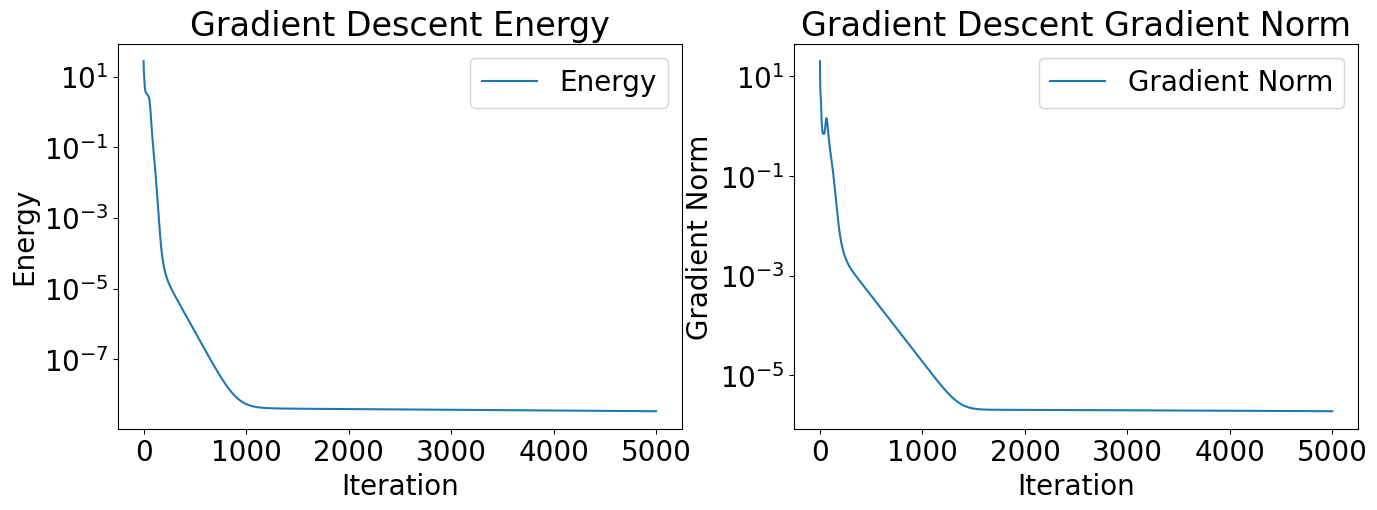

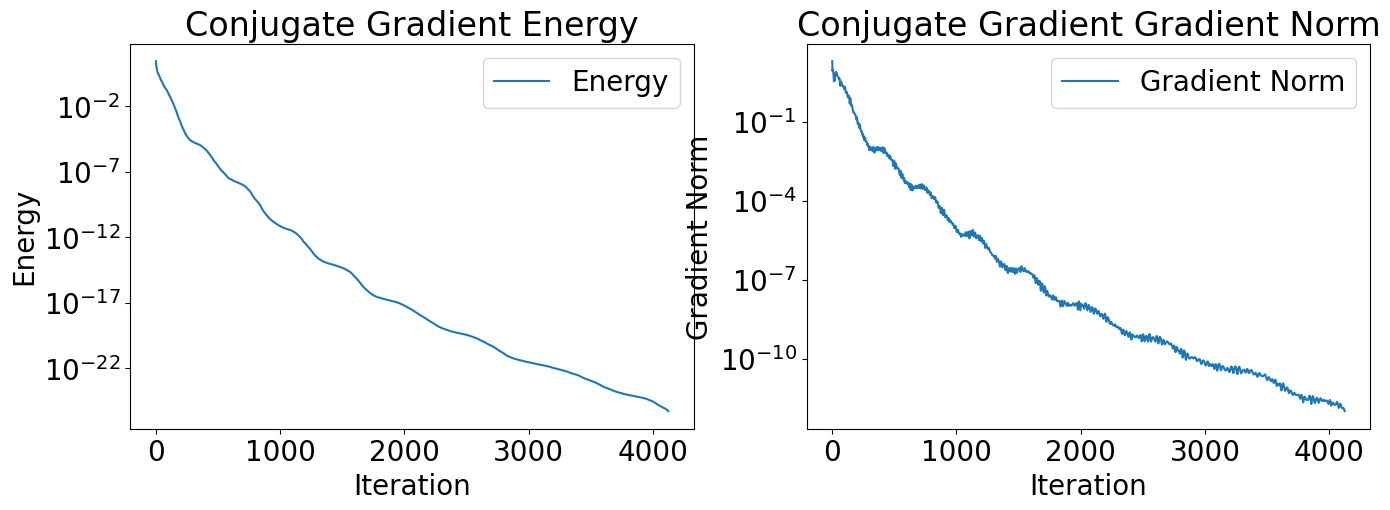

In [72]:
from scipy.optimize import minimize_scalar

np.random.seed(42)
theta_0 = np.random.uniform(0, 2 * np.pi, 12)
x_0 = np.random.uniform(-1, 1, 9)
y_0 = np.random.uniform(-1, 1, 9)
initial_vec = np.concatenate([theta_0, x_0, y_0])

def gradient_descent(func, grad_func, x_0, lr=0.1, max_iter=5000, tol=1e-12):
    x = x_0.copy()
    history = {"energy": [], "grad_norm": []}
    for _ in range(max_iter):
        g = grad_func(x)
        grad_norm = np.linalg.norm(g)
        history["energy"].append(func(x))
        history["grad_norm"].append(grad_norm)
        if grad_norm < tol:
            break
        x -= lr * g
    return x, history

result_gd, history_gd = gradient_descent(func, gradient, initial_vec)

def conjugate_gradient(func, grad_func, x_0, max_iter=5000, tol=1e-12):
    x = x_0.copy()
    g = grad_func(x)
    d = -g
    history = {"energy": [], "grad_norm": []}
    
    for _ in range(max_iter):
        grad_norm = np.linalg.norm(g)
        history["energy"].append(func(x))
        history["grad_norm"].append(grad_norm)
        
        if grad_norm < tol:
            break
        alpha = minimize_scalar(lambda alpha: func(x + alpha * d)).x
        x += alpha * d
        new_g = grad_func(x)
        beta = np.dot(new_g, new_g) / np.dot(g, g)
        d = -new_g + beta * d
        g = new_g
    
    return x, history

result_cg, history_cg = conjugate_gradient(func, gradient, initial_vec)

def plot_results(history, method_name):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["energy"], label='Energy')
    plt.title(f"{method_name} Energy")
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.yscale('log')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history["grad_norm"], label='Gradient Norm')
    plt.title(f"{method_name} Gradient Norm")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_results(history_gd, "Gradient Descent")
plot_results(history_cg, "Conjugate Gradient")


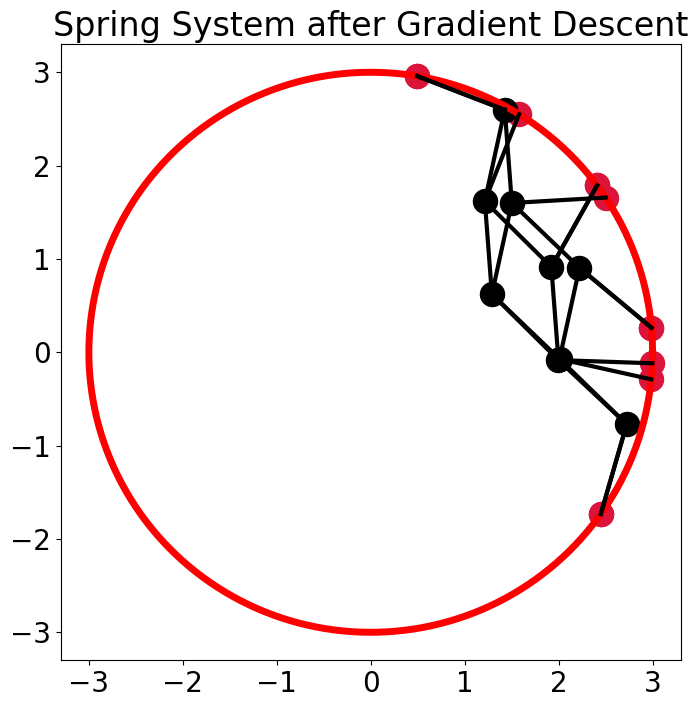

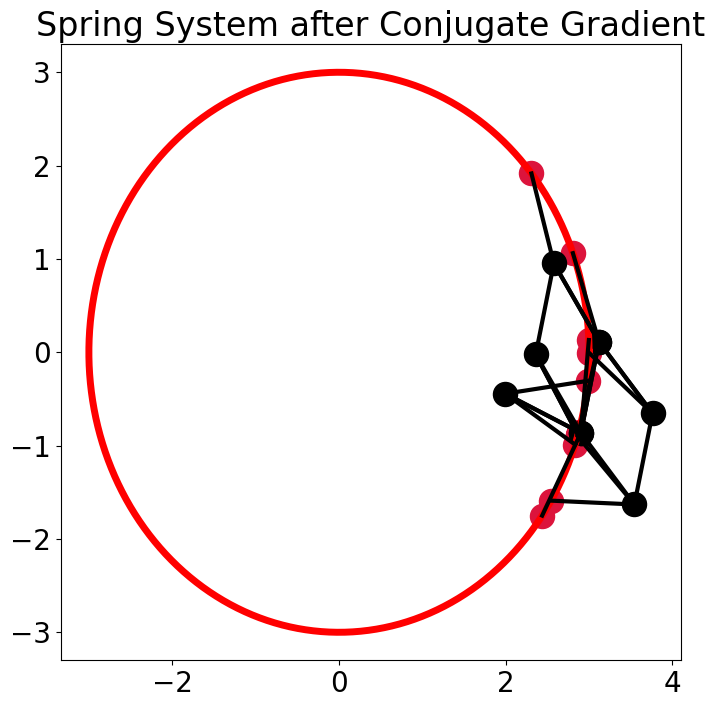

In [73]:
theta_gd, pos_gd = vec_to_pos(result_gd)

draw_spring_system(pos_gd, springs, R, ind_hoop, ind_free)
plt.title("Spring System after Gradient Descent")
plt.show()

theta_cg, pos_cg = vec_to_pos(result_cg)

draw_spring_system(pos_cg, springs, R, ind_hoop, ind_free)
plt.title("Spring System after Conjugate Gradient")
plt.show()

In [74]:
theta_gd, pos_gd = vec_to_pos(result_gd)
energy_gd = Energy(theta_gd, pos_gd, springs, r0, kappa)
grad_norm_gd = np.linalg.norm(gradient(result_gd))

print("Gradient Descent Results:")
print("Positions of nodes:")
print(pos_gd)
print(f"Resulting energy: {energy_gd}")
print(f"Norm of the gradient: {grad_norm_gd}")

theta_cg, pos_cg = vec_to_pos(result_cg)
energy_cg = Energy(theta_cg, pos_cg, springs, r0, kappa)
grad_norm_cg = np.linalg.norm(gradient(result_cg))

print("Gradient Conjugate Gradient Results:")
print("Positions of nodes:")
print(pos_cg)
print(f"Resulting energy: {energy_cg}")
print(f"Norm of the gradient: {grad_norm_cg}")

Gradient Descent Results:
Positions of nodes:
[[ 2.40971942  1.78696735]
 [ 2.99768273 -0.11789082]
 [ 2.44953481 -1.73198707]
 [ 2.40971942  1.78696735]
 [ 1.92292417  0.91345154]
 [ 1.99826779 -0.08370515]
 [ 2.72500701 -0.77067817]
 [ 2.44953481 -1.73198707]
 [ 1.5790074   2.55083038]
 [ 1.21478083  1.61951954]
 [ 1.29005871  0.62235609]
 [ 2.01005025 -0.07156808]
 [ 2.9859872  -0.28962119]
 [ 0.49492099  2.95889392]
 [ 1.42703685  2.59673371]
 [ 1.50231152  1.59957093]
 [ 2.22234947  0.90563641]
 [ 2.98845635  0.26292322]
 [ 0.49492099  2.95889392]
 [ 2.50064123  1.6573453 ]
 [ 2.98845635  0.26292322]]
Resulting energy: 3.3580880689138223e-09
Norm of the gradient: 1.9024929924971941e-06
Gradient Conjugate Gradient Results:
Positions of nodes:
[[ 2.83233197 -0.98888604]
 [ 2.43690186 -1.74971693]
 [ 2.86225931 -0.89859425]
 [ 2.98436144 -0.30591957]
 [ 1.99391949 -0.44384979]
 [ 2.90132592 -0.86410398]
 [ 3.54340251 -1.63074447]
 [ 2.54424975 -1.589589  ]
 [ 2.99712549  0.13129667]
